In [1]:
import os
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
output_paths = [
    # "/home/nadir/tmr-code/outputs/archive/start-end-segmentation_stgcn_mlp_babel-windowed_2025-05-26_15-54-17",
    # "/home/nadir/tmr-code/outputs/archive/start-end-segmentation_stgcn_mlp_babel-windowed_2025-05-26_15-54-19",
    # "/home/nadir/tmr-code/outputs/archive/start-end-segmentation_stgcn_mlp_babel-windowed_2025-05-26_15-54-21",
    # "/home/nadir/tmr-code/outputs/archive/start-end-segmentation_stgcn_mlp_babel-windowed_2025-05-26_15-54-23",
    # "/home/nadir/tmr-code/outputs/archive/start-end-segmentation_stgcn_mlp_babel-windowed_2025-05-26_15-54-25",
    "/home/nadir/tmr-code/outputs/archive/start-end-segmentation_tmr_mlp_babel-windowed_2025-05-26_15-54-27",
    "/home/nadir/tmr-code/outputs/archive/start-end-segmentation_tmr_mlp_babel-windowed_2025-05-26_15-54-30",
    "/home/nadir/tmr-code/outputs/archive/start-end-segmentation_tmr_mlp_babel-windowed_2025-05-26_15-54-31",
    "/home/nadir/tmr-code/outputs/archive/start-end-segmentation_tmr_mlp_babel-windowed_2025-05-26_15-54-33",
    "/home/nadir/tmr-code/outputs/archive/start-end-segmentation_tmr_mlp_babel-windowed_2025-05-26_15-54-36",
    "/home/nadir/tmr-code/outputs/archive/start-end-segmentation_tmr_mlp_babel-windowed_2025-05-26_15-54-38",
    "/home/nadir/tmr-code/outputs/archive/start-end-segmentation_tmr_mlp_babel-windowed_2025-05-26_15-54-40",
    "/home/nadir/tmr-code/outputs/archive/start-end-segmentation_tmr_mlp_babel-windowed_2025-05-26_15-54-43",
    "/home/nadir/tmr-code/outputs/archive/start-end-segmentation_tmr_mlp_babel-windowed_2025-05-26_15-54-45",
    "/home/nadir/tmr-code/outputs/archive/start-end-segmentation_tmr_mlp_babel-windowed_2025-05-26_15-54-47"
]

In [9]:
logs = list(map(lambda output_path: pd.read_csv(os.path.join(output_path, "logs", "metrics.csv")), output_paths))

In [13]:
global_min = float('inf')
global_max = float('-inf')
all_train_val_losses = []

loss_data = []

for output_path, log in zip(output_paths, logs):
    config = json.load(open(os.path.join(output_path, "config.json"), 'r'))
    
    window_size = int(re.search(r"/(\d+)-\d+/", config["data"]["dir"]).group(1))
    classifier = config["model"]["classifier"]["_target_"].split('.')[-1]
    motion_encoder = config["model"]["motion_encoder"]["_target_"].split('.')[-1]
    pretrained_motion_encoder = config["model"]["motion_encoder"].get("pretrained", False)
    
    title = f"{classifier};{motion_encoder}(pretrained={pretrained_motion_encoder}) (window size={window_size})"

    epoch_data = log[log['epoch'].notna()].copy()
    epochs = sorted(epoch_data['epoch'].unique())

    train_losses_epoch = []
    val_losses_epoch = []

    for epoch in epochs:
        epoch_rows = epoch_data[epoch_data['epoch'] == epoch]

        train_loss = epoch_rows['train_loss_step'].dropna()
        if len(train_loss) > 0:
            train_losses_epoch.append(train_loss.iloc[-1])
        else:
            train_epoch_loss = epoch_rows['train_loss_epoch'].dropna()
            train_losses_epoch.append(train_epoch_loss.iloc[-1] if len(train_epoch_loss) > 0 else np.nan)

        val_loss = epoch_rows['val_loss_step'].dropna()
        if len(val_loss) > 0:
            val_losses_epoch.append(val_loss.iloc[-1])
        else:
            val_epoch_loss = epoch_rows['val_loss_epoch'].dropna()
            val_losses_epoch.append(val_epoch_loss.iloc[-1] if len(val_epoch_loss) > 0 else np.nan)

    all_losses = train_losses_epoch + val_losses_epoch
    local_min = np.nanmin(all_losses)
    local_max = np.nanmax(all_losses)
    global_min = min(global_min, local_min)
    global_max = max(global_max, local_max)

    loss_data.append((epochs, train_losses_epoch, val_losses_epoch, title))

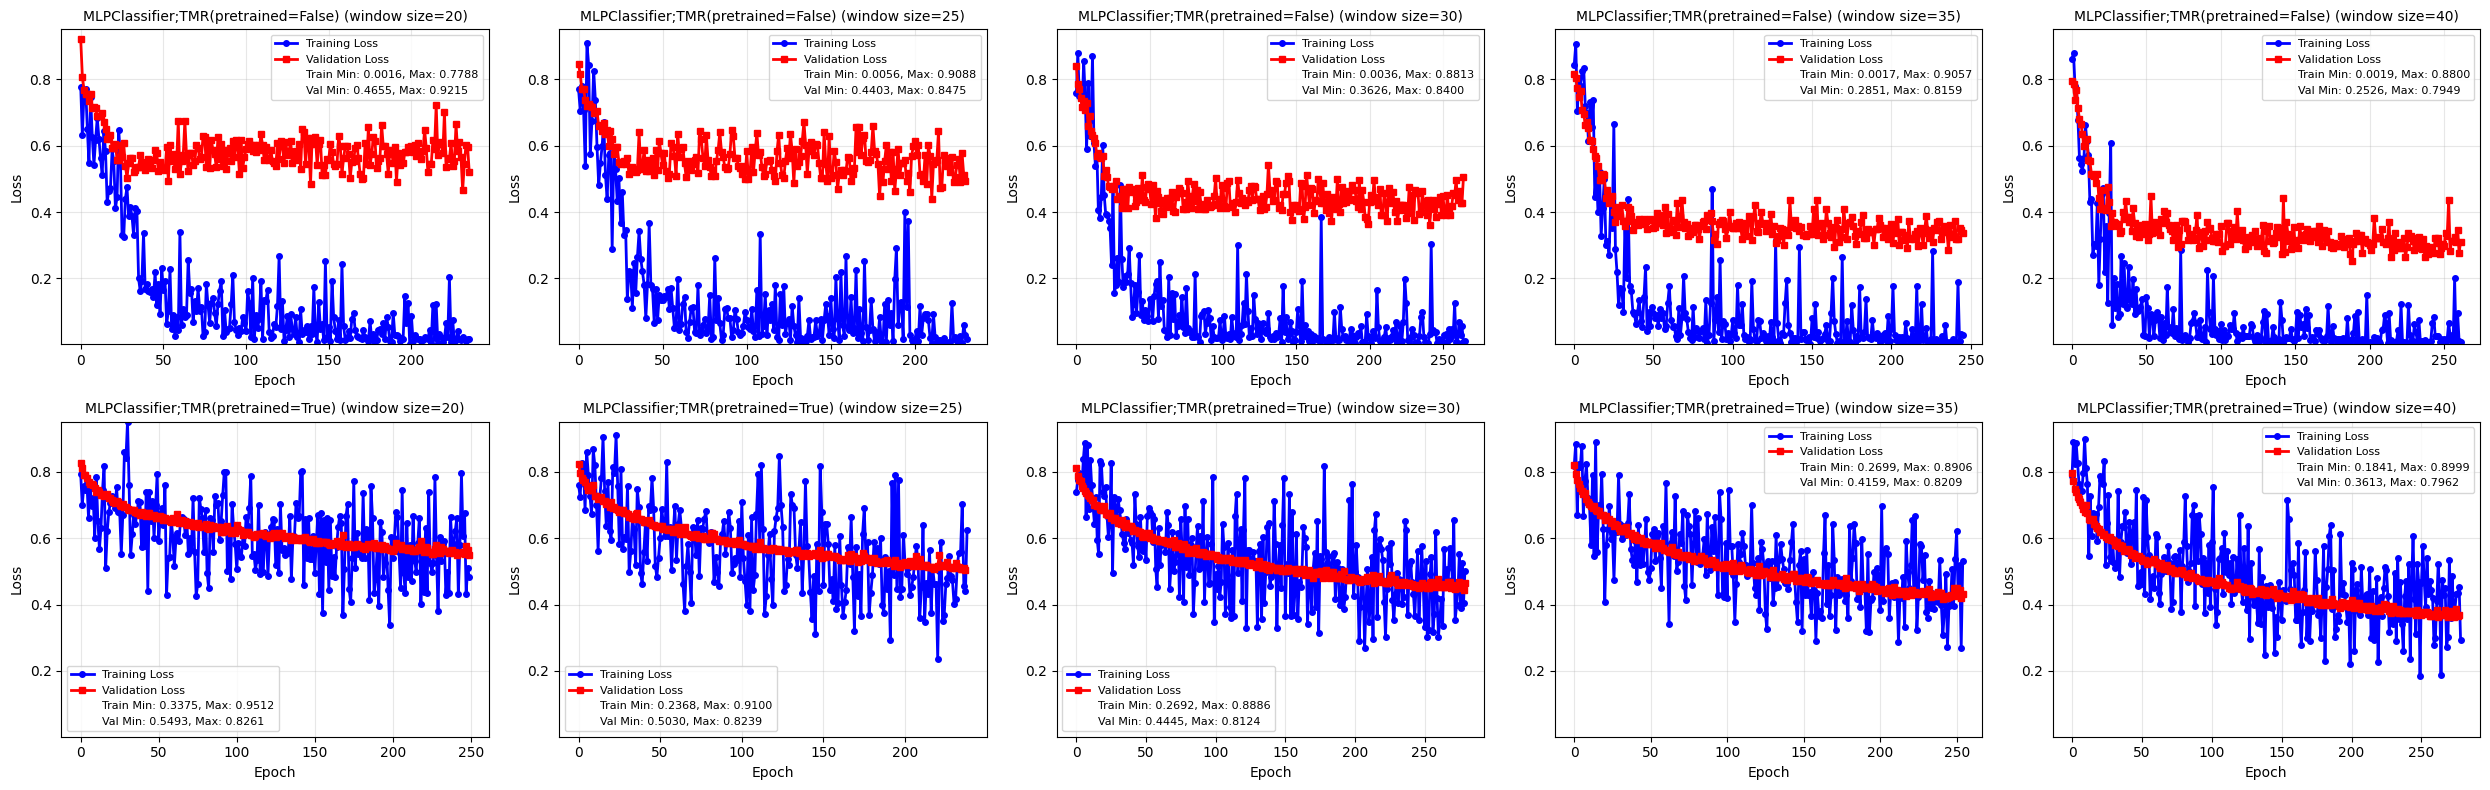

In [14]:
cols = 5
rows = int(np.ceil(len(loss_data) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), squeeze=False)

for idx, (epochs, train_losses, val_losses, title) in enumerate(loss_data):
    row, col = divmod(idx, cols)
    ax = axes[row][col]

    ax.plot(epochs, train_losses, 'b-o', label='Training Loss', linewidth=2, markersize=4)
    ax.plot(epochs, val_losses, 'r-s', label='Validation Loss', linewidth=2, markersize=4)
    ax.set_title(title, fontsize=10)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_ylim(global_min, global_max)
    ax.grid(True, alpha=0.3)

    train_min = np.nanmin(train_losses)
    train_max = np.nanmax(train_losses)
    val_min = np.nanmin(val_losses)
    val_max = np.nanmax(val_losses)

    extra_legend = [
        f"Train Min: {train_min:.4f}, Max: {train_max:.4f}",
        f"Val Min: {val_min:.4f}, Max: {val_max:.4f}"
    ]

    ax.legend(
        labels=["Training Loss", "Validation Loss"] + extra_legend,
        handles=[*ax.lines, plt.Line2D([], [], linestyle='None'), plt.Line2D([], [], linestyle='None')],
        fontsize=8
    )

# NOTE: hide unused subplots
for idx in range(len(loss_data), rows * cols):
    row, col = divmod(idx, cols)
    axes[row][col].axis('off')

plt.tight_layout()
plt.show()